In [1]:
## imports

import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from pprint import pprint

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os
root = os.path.expanduser('~')

company_index='5'
company_name='Amazon'
# img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/'+f'{company_index}_{company_name}'
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/LDA_vis'
img_flag = False

if not os.path.exists(img_path):
    os.makedirs(img_path)

In [2]:
## making dataset

def get_px_data(company_index=5, company_name='Amazon', uni=False, bi=False, tri=False):
    data_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/data/companies/'+f'{company_index}_{company_name}'+'/output_data/px_data1/cons.csv'
    df = pd.read_csv(data_path)
#     print(df.head())
    df_data = pd.DataFrame()
    df_data['Review_Text'] = df['Review_Text']
    if uni and bi and tri:
        df_data['Px_Texts'] = df['Unigrams'].fillna('') + ' ' + df['Bigrams'].fillna('') + ' ' + df['Trigrams'].fillna('')
    elif uni:
        df_data['Px_Texts'] = df['Unigrams'].dropna()
    elif bi:
        df_data['Px_Texts'] = df['Bigrams'].dropna()
    elif tri:
        df_data['Px_Texts'] = df['Trigrams'].dropna()
    
    return df_data
    
sentences = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=True, bi=True, tri=True)

# print(len(sentences))
# sentences[:5]
print(sentences.shape[0])
sentences.head()





14500


Review_Text  \
0  Unappreciated by management, Seasonal Driver u...   
1  During the winter is really cold inside the wa...   
2                                       Short breaks   
3  Not set schedule, bidding every few days, no m...   
4     Managers are very young and dont know the job.   

                                            Px_Texts  
0  benefit day dental driver exhaust manag manner...  
1            cold hot insid summer warehous winter    
2                           break short short_break   
3  bid day manag schedul set site slacker day_man...  
4                             dont manag manag_dont

In [3]:

def merge_data(company_list=[5], uni=False, bi=False, tri=False):
    sentences = []
    df_company_list = pd.read_csv( root + '/Desktop/workspace/indeed/Job-Satisfaction/data/scraper_data/review_site.csv')
    sentences = pd.DataFrame(columns = ['Review_Text', 'Px_Texts'])
    for company_index in company_list:
        company_name = df_company_list.iloc[company_index - 1]['Company_Name']
        px_sents = get_px_data(company_index=company_index, company_name=company_name, 
                        uni=uni, bi=bi, tri=tri)
        if (px_sents.shape[0]) < 1000:
            sentences = pd.concat([sentences, px_sents], ignore_index=True)
        else:
            sentences = pd.concat([sentences, px_sents.sample(n=1000, random_state=42)], ignore_index=True)
    return sentences

# sentences = merge_data(company_list=[5],
#                         uni=True, bi=True, tri=True)
sentences = merge_data(company_list=range(1, 51),
                        uni=True, bi=True, tri=True)
# sentences = merge_data(company_list=[5, 6, 7, 8, 9, 10],
#                         uni=True, bi=True, tri=True)
# print(len(sentences))
sentences.head()

Review_Text  \
0                                    Short Breaks   
1                                  no health care   
2  low pay, inconsistent support from management.   
3                 Benefits, no overtime, payscale   
4                        The length of the breaks   

                                            Px_Texts  
0                           break short short_break   
1                           care health health_care   
2  inconsist low manag pay support low_pay suppor...  
3                                  benefit overtim    
4                                            break

In [4]:
## tokenizing

sent_list = sentences[['Px_Texts']].values

data_px = []
for sent in sent_list:
    data_px.append(sent[0].split())

sentences['Tokenized_Texts'] = data_px
sentences.head()

Review_Text  \
0                                    Short Breaks   
1                                  no health care   
2  low pay, inconsistent support from management.   
3                 Benefits, no overtime, payscale   
4                        The length of the breaks   

                                            Px_Texts  \
0                           break short short_break    
1                           care health health_care    
2  inconsist low manag pay support low_pay suppor...   
3                                  benefit overtim     
4                                            break     

                                     Tokenized_Texts  
0                        [break, short, short_break]  
1                        [care, health, health_care]  
2  [inconsist, low, manag, pay, support, low_pay,...  
3                                 [benefit, overtim]  
4                                            [break]

In [5]:
sentences.shape

(43071, 3)

In [6]:
# Create Dictionary
id2word = corpora.Dictionary(data_px) ##dictionary
print(len(id2word))
print(id2word)

# Create Corpus
texts = data_px 

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]  ##corpus

# View
# print(corpus[:1])
print(corpus[:5])

14902
Dictionary(14902 unique tokens: ['break', 'short', 'short_break', 'care', 'health']...)
[[(0, 1), (1, 1), (2, 1)], [(3, 1), (4, 1), (5, 1)], [(6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)], [(13, 1), (14, 1)], [(0, 1)]]


In [7]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:4]]

[[('break', 1), ('short', 1), ('short_break', 1)],
 [('care', 1), ('health', 1), ('health_care', 1)],
 [('inconsist', 1),
  ('low', 1),
  ('low_pay', 1),
  ('manag', 1),
  ('pay', 1),
  ('support', 1),
  ('support_manag', 1)],
 [('benefit', 1), ('overtim', 1)]]

In [8]:
# %%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = root + '/Downloads/mallet-2.0.8/bin/mallet' # update this path
%time ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word, iterations=1000, random_seed=42)

CPU times: user 582 ms, sys: 16.6 ms, total: 598 ms
Wall time: 45.5 s


In [9]:
# Compute Coherence Score
%time coherence_model_lda = CoherenceModel(model=ldamallet, texts=data_px, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 4.19 ms, sys: 2.04 ms, total: 6.22 ms
Wall time: 12 ms

Coherence Score:  0.39999246674219424


In [10]:
##mallet model to lda model conversion

optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [12]:
# %%time
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='tsne')
vis
# pyLDAvis.show(vis)

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
5        2.997853 -152.612991       1        1  5.072247
11     142.394012  -23.886156       2        1  5.054708
0      -45.751396   77.163620       3        1  5.045123
6       76.305847 -141.926926       4        1  5.040405
12      13.011635  116.017036       5        1  5.036926
15       6.809924  -45.157932       6        1  5.024618
1      -23.545193   13.512723       7        1  5.013421
19     141.677475   48.094456       8        1  5.003033
3       22.074842   53.780216       9        1  5.002610
14     -81.528503 -106.585686      10        1  5.001463
16      78.233757  -42.136166      11        1  4.999990
9      -20.819592  -95.886200      12        1  4.984689
7      -50.684586  -38.344955      13        1  4.982942
13      79.937614   87.427116      14        1  4.978958
4      -88.210678   26.423840      15        1  4.973126
18      43.545460  -89.268143      16        1  4.972946
17     122.555191  -89.836067      17        1  4.968927
2     -111.965469  -38.001984      18        1  4.967495
10      34.924652   -1.084678      19        1  4.955783
8       85.734612   20.366827      20        1  4.920594, topic_info=     Category         Freq         Term        Total  loglift  logprob
77    Default  3688.000000         hour  3688.000000  30.0000  30.0000
9     Default  5526.000000        manag  5526.000000  29.0000  29.0000
0     Default  2983.000000        break  2983.000000  28.0000  28.0000
10    Default  2360.000000          pay  2360.000000  27.0000  27.0000
1     Default  2197.000000        short  2197.000000  26.0000  26.0000
2     Default  1615.000000  short_break  1615.000000  25.0000  25.0000
75    Default  1608.000000       advanc  1608.000000  24.0000  24.0000
47    Default  2357.000000         time  2357.000000  23.0000  23.0000
20    Default  1322.000000         poor  1322.000000  22.0000  22.0000
125   Default  1182.000000       stress  1182.000000  21.0000  21.0000
16    Default  1156.000000         lack  1156.000000  20.0000  20.0000
7     Default  1111.000000          low  1111.000000  19.0000  19.0000
160   Default  1088.000000       balanc  1088.000000  18.0000  18.0000
13    Default  1229.000000      benefit  1229.000000  17.0000  17.0000
23    Default   997.000000          day   997.000000  16.0000  16.0000
180   Default   890.000000        chang   890.000000  15.0000  15.0000
42    Default  1133.000000      employe  1133.000000  14.0000  14.0000
64    Default   858.000000        lunch   858.000000  13.0000  13.0000
266   Default   817.000000        shift   817.000000  12.0000  12.0000
92    Default   892.000000         hard   892.000000  11.0000  11.0000
428   Default   790.000000         life   790.000000  10.0000  10.0000
128   Default   778.000000          lot   778.000000   9.0000   9.0000
53    Default   758.000000          bad   758.000000   8.0000   8.0000
359   Default   719.000000      environ   719.000000   7.0000   7.0000
37    Default   944.000000      schedul   944.000000   6.0000   6.0000
28    Default   702.000000       custom   702.000000   5.0000   5.0000
105   Default   652.000000        peopl   652.000000   4.0000   4.0000
33    Default   628.000000      sometim   628.000000   3.0000   3.0000
403   Default   606.000000     opportun   606.000000   2.0000   2.0000
8     Default   601.000000      low_pay   601.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
6903  Topic20    55.975880         bank    55.975880   3.0117  -4.8541
820   Topic20    54.899421       excess    54.899421   3.0117  -4.8735
1017  Topic20    53.822961        space    53.822961   3.0117  -4.8934
2892  Topic20    51.670043        divis    51.670043   3.0117  -4.9342
175   Topic20    43.058369       favort    43.058369   3.0117  -5.1165
993   Topic20    39.828991        nepot    39.828991   3.0117  -5.1945
465  

In [670]:
#parameter tuning (finding the best model)
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word, 
                                                 iterations=500, random_seed=42)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [671]:
#  Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_px, start=2, limit=40, step=2)

KeyboardInterrupt: 

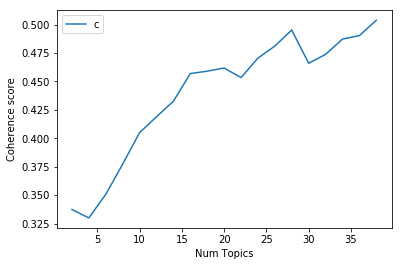

In [591]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [14]:
num_topics = 20
from collections import OrderedDict
def get_doc_topic_dist(model=optimal_model, corpus=corpus, kwords=False):
    
    '''
    LDA transformation, for each doc only returns topics with non-zero weight
    This function makes a matrix transformation of docs in the topic space.
    '''
    top_dist =[]
    keys = []

    for d in corpus:
        tmp = {i:0 for i in range(num_topics)}
        tmp.update(dict(model[d]))
        vals = list(OrderedDict(tmp).values())
        top_dist += [np.array(vals)]
        if kwords:
            keys += [np.array(vals).argmax()]

    return np.array(top_dist), keys

top_dist, keys = get_doc_topic_dist(optimal_model, corpus, kwords=True)
print(top_dist[:5])
print(keys[:5])

[[0.04716981 0.04716981 0.04716981 0.04716981 0.04716981 0.10160735
  0.04716981 0.04716981 0.04716981 0.04717197 0.04716981 0.04716981
  0.04933389 0.04716981 0.04716981 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981]
 [0.04716981 0.04716981 0.04717974 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981 0.04716981 0.04719711 0.04716981 0.04716981
  0.04716981 0.10373636 0.04716981 0.04716981 0.04716981 0.04716981
  0.04716981 0.04716981]
 [0.08262897 0.04385965 0.04385965 0.04385965 0.04385965 0.04385965
  0.0518107  0.04385965 0.04385965 0.0438635  0.06130632 0.09648738
  0.04385965 0.04385965 0.04783069 0.04385965 0.04577185 0.04398481
  0.04385965 0.04385965]
 [0.04807692 0.04807692 0.04807692 0.04807692 0.04807692 0.04807692
  0.04807692 0.04807692 0.04807692 0.04807692 0.04807692 0.04807692
  0.04807692 0.05086402 0.04807692 0.04807692 0.04807692 0.04807692
  0.0645206  0.06730769]
 [0.04901961 0.04901961 0.04901961 0.04901961 0.04901961 0.06493549
  0.04901961 0.0

In [727]:
def explore_topic(lda_model, topic_number, topn, output=True):
    """
    accept a ldamodel, atopic number and topn vocabs of interest
    prints a formatted list of the topn terms
    """
    terms = []
    for term, frequency in lda_model.show_topic(topic_number, topn=topn):
        terms += [term]
        if output:
            print(u'{:20} {:.3f}'.format(term, round(frequency, 3)))
    
    return terms

explore_topic(optimal_model, 0, 3)

lack                 0.157
manag                0.098
train                0.077


['lack', 'manag', 'train']

In [728]:
topic_summaries = []
num_topics = 20
# print(u'{:20} {}'.format(u'term', u'frequency') + u'\n')
for i in range(num_topics):
#     print('Topic '+str(i)+' |---------------------\n')
    tmp = explore_topic(optimal_model,topic_number=i, topn=3, output=False )
#     print tmp[:5]
    topic_summaries += [tmp[:5]]
    print
    
print(topic_summaries)

# for t in topic_labels:
#     print(" ".join(t))
topic_label = [" ".join(t) for t in topic_summaries]
print(topic_label)

[['lack', 'manag', 'train'], ['advanc', 'opportun', 'littl'], ['stress', 'shift', 'environ'], ['lot', 'custom', 'peopl'], ['posit', 'secur', 'contract'], ['break', 'short', 'short_break'], ['manag', 'poor', 'poor_manag'], ['time', 'busi', 'salari'], ['con', 'polit', 'home'], ['hard', 'slow', 'promot'], ['hour', 'schedul', 'week'], ['pay', 'low', 'low_pay'], ['lunch', 'break', 'call'], ['employe', 'health', 'care'], ['manag', 'bad', 'team'], ['balanc', 'life', 'cultur'], ['manag', 'employe', 'dont'], ['time', 'sometim', 'move'], ['benefit', 'day', 'healthcar'], ['chang', 'overtim', 'layoff']]
['lack manag train', 'advanc opportun littl', 'stress shift environ', 'lot custom peopl', 'posit secur contract', 'break short short_break', 'manag poor poor_manag', 'time busi salari', 'con polit home', 'hard slow promot', 'hour schedul week', 'pay low low_pay', 'lunch break call', 'employe health care', 'manag bad team', 'balanc life cultur', 'manag employe dont', 'time sometim move', 'benefit da

In [729]:
top_labels = dict()

for i in range(num_topics):
    top_labels[i] = topic_label[i]
    
print(top_labels)

{0: 'lack manag train', 1: 'advanc opportun littl', 2: 'stress shift environ', 3: 'lot custom peopl', 4: 'posit secur contract', 5: 'break short short_break', 6: 'manag poor poor_manag', 7: 'time busi salari', 8: 'con polit home', 9: 'hard slow promot', 10: 'hour schedul week', 11: 'pay low low_pay', 12: 'lunch break call', 13: 'employe health care', 14: 'manag bad team', 15: 'balanc life cultur', 16: 'manag employe dont', 17: 'time sometim move', 18: 'benefit day healthcar', 19: 'chang overtim layoff'}


In [731]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(
#                             analyzer='word',       
#                              min_df=10,                        # minimum reqd occurences of a word 
#                              stop_words='english',             # remove stop words
#                              lowercase=True                   # convert all words to lowercase
#                              token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

# display(sentences[['Px_Texts']].values.tolist())
sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# display(sents)
# display(sentences[['Px_Texts']].values)
data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
print(data_vectorized[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# vectorizer = CountVectorizer()

# sents = [s[0] for s in sentences[['Px_Texts']].values.tolist()]
# data_vectorized = vectorizer.fit_transform(sents).toarray() ##dtm
# print(data_vectorized[:5])


In [732]:
top_dist, lda_keys= get_doc_topic_dist(optimal_model, corpus, True)
features = vectorizer.get_feature_names()
print(len(features))

14887


In [761]:
print(len(top_dist))
threshold = 0.06
# threshold = 1/num_topics
_idx = np.amax(top_dist, axis=1) > threshold  # idx of doc that above the threshold
X_topic = top_dist[_idx]
print(len(X_topic))

43071
38532


In [762]:
dtm = data_vectorized

In [763]:
p_df = pd.DataFrame()
p_df['tokenz'] = np.asarray(data_px)[_idx]
p_df.head()

tokenz
0                        [break, short, short_break]
1                        [care, health, health_care]
2  [inconsist, low, manag, pay, support, low_pay,...
3                                 [benefit, overtim]
4                                            [break]

In [764]:
display(dtm)
print(p_df.shape)
print(len(X_topic))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(38532, 1)
38532


In [765]:
sentences[['Review_Text']].values

array([['Short Breaks'],
       ['no health care'],
       ['low pay, inconsistent support from management.'],
       ...,
       ['none'],
       ['breaks are not very flexible'],
       ['You must know how to play the corporate game or you will find yourself out the door.']],
      dtype=object)

In [766]:
top_ws = []
for n in range(len(dtm)):
    inds = np.int0(np.argsort(dtm[n])[::-1][:4])
    tmp = [features[i] for i in inds]    
    top_ws += [' '.join(tmp)]


p_df['Text_Rep'] = pd.DataFrame(np.asarray(top_ws)[_idx])
p_df['clusters'] = pd.DataFrame(np.asarray(lda_keys)[_idx])
p_df['clusters'].fillna(20, inplace=True)
p_df['Review_Text'] = pd.DataFrame(sentences[['Review_Text']].values[_idx])
# p_df['Review_Text'] = sentences['Review_Text'].ix[_idx]


colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5"
])

cluster_colors = dict()
for c in range(num_topics): 
    cluster_colors[c] = colormap[c]
    
print(cluster_colors)
# cluster_colors = {0: 'blue', 1: 'green', 2: 'yellow', 3: 'red', 4: 'skyblue', 5:'salmon', 6:'orange', 
#                   7:'maroon', 8:'crimson', 9:'black', 10:'gray', 11: '#8c564b'}

p_df['colors'] = p_df['clusters'].apply(lambda l: cluster_colors[l])





{0: '#1f77b4', 1: '#aec7e8', 2: '#ff7f0e', 3: '#ffbb78', 4: '#2ca02c', 5: '#98df8a', 6: '#d62728', 7: '#ff9896', 8: '#9467bd', 9: '#c5b0d5', 10: '#8c564b', 11: '#c49c94', 12: '#e377c2', 13: '#f7b6d2', 14: '#7f7f7f', 15: '#c7c7c7', 16: '#bcbd22', 17: '#dbdb8d', 18: '#17becf', 19: '#9edae5'}


In [767]:
p_df.shape

(38532, 5)

In [768]:
from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2)
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

X_tsne = tsne.fit_transform(X_topic)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 38532 samples in 0.051s...
[t-SNE] Computed neighbors for 38532 samples in 44.097s...
[t-SNE] Computed conditional probabilities for sample 1000 / 38532
[t-SNE] Computed conditional probabilities for sample 2000 / 38532
[t-SNE] Computed conditional probabilities for sample 3000 / 38532
[t-SNE] Computed conditional probabilities for sample 4000 / 38532
[t-SNE] Computed conditional probabilities for sample 5000 / 38532
[t-SNE] Computed conditional probabilities for sample 6000 / 38532
[t-SNE] Computed conditional probabilities for sample 7000 / 38532
[t-SNE] Computed conditional probabilities for sample 8000 / 38532
[t-SNE] Computed conditional probabilities for sample 9000 / 38532
[t-SNE] Computed conditional probabilities for sample 10000 / 38532
[t-SNE] Computed conditional probabilities for sample 11000 / 38532
[t-SNE] Computed conditional probabilities for sample 12000 / 38532
[t-SNE] Computed conditional probabilities for sa

In [769]:
p_df['X_tsne'] =X_tsne[:, 0]
p_df['Y_tsne'] =X_tsne[:, 1]
len(X_tsne[:, 0])

38532

In [770]:
display(p_df.head())
# print(p_df.shape)
print(p_df.iloc[4]['Review_Text'])

tokenz  \
0                        [break, short, short_break]   
1                        [care, health, health_care]   
2  [inconsist, low, manag, pay, support, low_pay,...   
3                                 [benefit, overtim]   
4                                            [break]   

                                  Text_Rep  clusters  \
0               short_break short break él         5   
1               health_care care health él        13   
2  support_manag inconsist support low_pay        11   
3        overtim benefit él financi_servic        19   
4      break él financi_servic finish_oper         5   

                                      Review_Text   colors     X_tsne  \
0                                    Short Breaks  #98df8a  72.634834   
1                                  no health care  #f7b6d2  27.661394   
2  low pay, inconsistent support from management.  #c49c94  -9.318253   
3                 Benefits, no overtime, payscale  #9edae5  -1.251065   
4                        The length of the breaks  #98df8a  58.975109   

      Y_tsne  
0  12.613086  
1 -28.068792  
2 -52.558731  
3 -17.103151  
4  24.289524

The length of the breaks


In [771]:
from bokeh.plotting import figure, show, output_notebook, save#, output_file
from bokeh.models import HoverTool, value, LabelSet, Legend, ColumnDataSource
output_notebook()

Loading BokehJS ...

In [772]:
source = ColumnDataSource(dict(
    x=p_df['X_tsne'],
    y=p_df['Y_tsne'],
    color=p_df['colors'],
    label=p_df['clusters'].apply(lambda l: top_labels[l]),
#     msize= p_df['marker_size'],
    topic_key= p_df['clusters'],
    content = p_df['tokenz'],
    review_text = p_df['Review_Text']
))

In [774]:
title = 'T-SNE visualization of topics'

plot_lda = figure(plot_width=1000, plot_height=600,
                     title=title, tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
                     x_axis_type=None, y_axis_type=None, min_border=1)

plot_lda.scatter(x='x', y='y', legend='label', source=source,
                 color='color', alpha=0.8)#'msize', )

# hover tools
hover = plot_lda.select(dict(type=HoverTool))
hover.tooltips = {"content": "KeyWords: @content <br> ReviewText: @review_text <br> Topic: @label "}
plot_lda.legend.location = "top_left"

show(plot_lda)

#save the plot
img_path = root + '/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons'
save(plot_lda, img_path+'/cluster4.html')

'/Users/bishalsainju/Desktop/workspace/indeed/Job-Satisfaction/img/companies/clustering/cons/cluster4.html'